This script is for generating a suite of randomised models from an input 1D model. //
Written by Hanna-Riia Allas

In [1]:
# IMPORT PACKAGES

import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random


In [2]:
#===============================================================================================================================
# OPTIONS
#===============================================================================================================================

# working directory
directory = "1D_models_1kl"

# name of input model
initial_model = "NEW_oneit"

# number of random models to generate
no_rnd = 100

# model grid spacing with depth in km
grid = 1

# max perturbation of original model grid nodes in percent
max_perturbation = 5


In [3]:
# DEFINE FILEPATHS

parent_dir = "/raid4/hra35" # parent directory
models_path = os.path.join(parent_dir, directory) # path to working 1D model directory

input_model_path = os.path.join(models_path, "%s.vel" %initial_model)
esme_model_path = os.path.join(models_path, f"esme_{str(grid)}k.vel")
sm_model_path = os.path.join(models_path, "sm_avg.vel")

random_models_path = os.path.join(models_path, "random_models") # directory containing the random models generated from input model  

In [4]:
# READ IN INITIAL MODEL AND ESME'S MODEL

initial_model_df = pd.read_csv(input_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
esme_df = pd.read_csv(esme_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
sm_df = pd.read_csv(sm_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")


In [5]:
# DEFINE FUNCTION TO PERTURB THE VELOCITY NODE VALUES

def modify_value(val):
    change = max_perturbation/100
    percentage_change = random.uniform(-change, change)
    change = val * percentage_change
    return val + change


In [6]:
# PERTURB INPUT MODEL AND SAVE RESULTING MODELS INTO FILES

# dictionary to store the random model dataframes for plotting
random_model_dict = {}

for i in range(no_rnd):
    
    # make a copy of initial model
    random_model = initial_model_df.copy()
    
    # perturb each velocity value by up to 10%
    Vp = random_model["Vp"]
    Vs = random_model["Vs"]    
    Vp = Vp.apply(modify_value)
    Vs = Vs.apply(modify_value)

    random_model["Vp"] = Vp
    random_model["Vs"] = Vs
        
    # add top and bottom buffer velocity values to the model for FMTOMO
    top_row = {"depth": -10, "Vp": Vp[0], "Vs": Vs[0]}    
    bottom_row = {"depth": 20, "Vp": Vp[(len(Vp)-1)], "Vs": Vs[(len(Vs)-1)]}
    
    random_model = random_model.append(bottom_row, ignore_index=True)
    top_df = pd.DataFrame([top_row])
    final_df = top_df.append(random_model, ignore_index=True)
    
    random_model = final_df
    
    # save the random model into file
    random_model_path = os.path.join(random_models_path, f"rnd_{i}.vel")
    random_model.to_csv(random_model_path, index=False, header=False, sep="\t", float_format="%.6f")
    
    # save to dictionary
    random_model_dict[i] = random_model


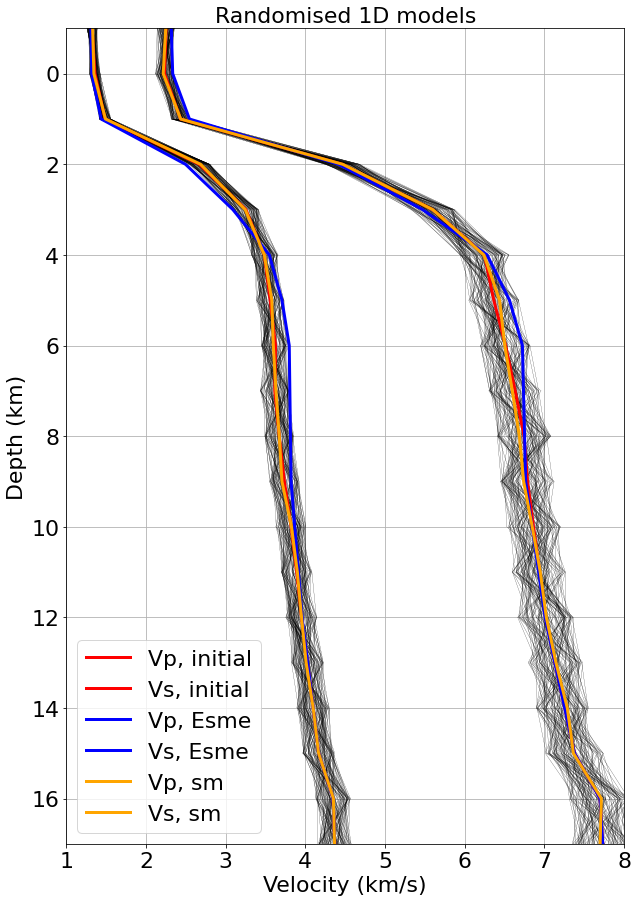

In [7]:
# PLOT THE RANDOM MODELS

plt.figure(figsize=(10, 15))

depth = random_model_dict[0]['depth']
for i in range(no_rnd):
#for i in range(5):
    plt.plot(random_model_dict[i]['Vp'], depth, linewidth=0.2, linestyle='-', color="black")
    plt.plot(random_model_dict[i]['Vs'], depth, linewidth=0.2, linestyle='-', color="black")

plt.plot(initial_model_df['Vp'], initial_model_df['depth'], linestyle='-', linewidth=3, label="Vp, initial", color='red')
plt.plot(initial_model_df['Vs'], initial_model_df['depth'], linestyle='-', linewidth=3, label="Vs, initial", color='red')

plt.plot(esme_df['Vp'], esme_df['depth'], linewidth=3, linestyle='-', label="Vp, Esme", color='blue')
plt.plot(esme_df['Vs'], esme_df['depth'], linewidth=3, linestyle='-', label="Vs, Esme", color='blue')

plt.plot(sm_df['Vp'], sm_df['depth'], linewidth=3, linestyle='-', label="Vp, sm", color='orange')
plt.plot(sm_df['Vs'], sm_df['depth'], linewidth=3, linestyle='-', label="Vs, sm", color='orange')

plt.ylim(-1,17)
plt.gca().invert_yaxis()
plt.xlim(1,8)
plt.xlabel('Velocity (km/s)', fontsize=22)
plt.ylabel('Depth (km)', fontsize=22)
plt.title("Randomised 1D models", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
plt.legend(fontsize=22)

#plt.show()